# Projet 2 - Conditional Variational Auto Encoders (CVAE)


## Introduction



Avant d'introduire le CVAE nous allons d'abord faire quelques rappels sur le VAE. Le fonctionnement du VAE est le suivant : un ensemble de variables latentes z est généré à partir de la distribution préalable $p_θ(z)$ et les données x sont générées par la distribution générative $p_θ (x|z)$ conditionnée par z : $z ∼ p_θ (z)$, $x ∼ p_θ (x|z)$. En général, l'estimation des paramètres est souvent difficile en raison de l'inférence à posteriori irréalisable. Toutefois, les paramètres du VAE peuvent être estimés efficacement dans le cadre de Bayes variationnel à gradient stochastique (SGVB). On aura donc une fonction loss de la forme suivante : $$L_{VAE}(x; θ, φ) = −KL (q_{φ}(z|x)∥p_{θ}(z)) +
\frac{1}{L} \sum_{l=1}^{L} log(p_θ(x|z^{(l)}))$$
avec une distribution $q_φ(z|x)$ est introduite pour approximer la vraie distribution $p_θ(z|x)$ et $z^{(l)} = g_φ(x,ε^{(l)}), ε^{(l)} ∼ \mathcal{N}(0,I)$.


L'inconvénient d'un VAE est que lorsque l'on génère des images sur un modèle entrainé, on ne contrôle pas la sortie et on obtient donc des images avec des labels aléatoires. Pour cela on introduit le Conditional VAE (CVAE) dont le but est de pouvoir spécifier le label voulu lorsque l'on génère des images sur un CVAE entrainé.

Le processus conditionnel du modèle est présenté comme suit : pour une observation x donnée, z est tiré de la distribution préalable $p_θ (z|x)$, et la sortie y est générée à partir de la distribution $p_θ (y|x, z)$. On observe donc qu'à la différence du VAE on va entrainer notre modèle avec les labels. Cette fois-ci notre loss s'écrit de la sorte :

$$L_{CVAE}(x; θ, φ) = −KL (q_{φ}(z|x,y)∥p_{θ}(z|x)) +
\frac{1}{L} \sum_{l=1}^{L} log(p_θ(y|x,z^{(l)}))$$
avec $z^{(l)} = g_φ(x,y,ε^{(l)}), ε^{(l)} ∼ \mathcal{N}(0,I)$.



## Chargement des librairies

In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import matplotlib.pyplot as plt

# cuda setup
device = torch.device("cuda")
kwargs = {'num_workers': 1, 'pin_memory': True}

## Chargement des données d'entrainement, de validation et de test

In [2]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader

batch_size = 128

transform = transforms.Compose([transforms.ToTensor()])

# Data loading
train_dataset = datasets.FashionMNIST(root='../../data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='../../data', train=False, transform=transform, download=True)

validation_ratio = 0.2
train_size = int((1 - validation_ratio) * len(train_dataset))
validation_size = len(train_dataset) - train_size

train_dataset, validation_dataset = random_split(train_dataset, [train_size, validation_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Vérification des tailles
print(f"Taille du train_loader: {len(train_loader.dataset)}")
print(f"Taille du validation_loader: {len(validation_loader.dataset)}")
print(f"Taille du test_loader: {len(test_loader.dataset)}")

Taille du train_loader: 48000
Taille du validation_loader: 12000
Taille du test_loader: 10000


## CVAE

Le CVAE est une amélioration d'un VAE. Comme présenté précédemment la limite d'un VAE réside dans le fait que l'on va générer des images aléatoire et on a aucun contrôle sur le label de sortie. Ce que l'on cherche à faire avec un CVAE c'est de forcer la sortie en précisant le label que l'on veut. Pour cela, on va s'appuyer sur des probabilités conditionnelles.

Dans un CVAE, le but est de minimiser l’erreur de reconstruction de l’entrée à la sortie. La sortie d’un CVAE est souvent comparée pixel par pixel à l'entrée, et chaque sortie est traitée indépendemment. La fonction sigmoïde est idéale dans ce cas, car elle comprime les valeurs de sortie dans l'intervalle [0,1], correspondant à une interprétation de probabilité ou d'intensité de pixel. Elle permet donc de bien modéliser la distribution des valeurs de pixels dans la sortie.

Pour l'encodeur on va utiliser des couches de convolution 2d d'une part parce que l'on a des images donc en 2 dimensions et d'autre part car l'on cherche à réduire la dimension. Pour le décodeur on va utiliser des couches de convolutions transposées pour augmenter la dimension et revenir aux dimensions de l'image en entrée. 

### Architecture CVAE

In [132]:
class CVAE(nn.Module):
    def __init__(self, latent_dim, num_classes):
        super(CVAE, self).__init__()

        # On récupère les arguments passés au modèle
        self.latent_dim = latent_dim
        self.num_classes = num_classes

        # Encodeur
        self.encoder = nn.Sequential(
            
            # On met 2 objets, l'image et les labels (num_classes)
            nn.Conv2d(1 + num_classes, 32, kernel_size=4, stride=2, padding=1),  # Output: (32,14,14)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # Output: (64, 7, 7)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Output: (128, 4, 4)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
        )

        # Espace latent
        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)
        
        # On a besoin des labels pour décoder donc on rajoute num_classes
        self.fc_decode = nn.Linear(latent_dim + num_classes, 128 * 4 * 4)

        # Decodeur
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1),  # Output: (64, 8, 8)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # Output: (32, 16, 16)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # Output: (1, 28, 28)
            nn.Sigmoid()
        )

    # On encode en connaissant les labels
    def encode(self, x, labels):

        # Mettre les labels de même dimension que les images
        
        # Transformation en un one-hot vecteur => que des 0 sauf un 1 positionné à la classe correspondante
        labels_onehot = F.one_hot(labels, num_classes=self.num_classes).float() # Output : (labels.size, num_classes) 
        
        labels_onehot = labels_onehot.view(labels.size(0), self.num_classes, 1, 1) # Output : (labels.size, num_classes,1,1)
        # exemple : labels_onehot = tensor([[[[0.]], [[1.]], [[0.]], ..., [[0.]], [[0.]], [[0.]]],
        #                                    [[0.]], [[0.]], [[0.]], ..., [[0.]], [[1.]], [[0.]]])
        
        labels_onehot = labels_onehot.expand(labels.size(0), self.num_classes, 28, 28) # Output : (labels.size, num_classes,28,28)

        # On encode avec l'image et les labels
        x = torch.cat([x, labels_onehot], dim=1)

        x = self.encoder(x)

        # Format image -> Flatten
        x = x.view(-1,128 * 4 * 4)

        # Calcul des paramètres pour la simulation
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        
        return mu, logvar

    # Simulation des probabilités
    def sample(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    # On utilise les labels pour décoder
    def decode(self, z, labels):
        labels_onehot = F.one_hot(labels, num_classes=self.num_classes).float() # Output : (labels.size, num_classes) 
        
        # On décode avec les labels
        z = torch.cat([z, labels_onehot], dim=1)
        x = self.fc_decode(z)

        # Flatten -> Format image
        x = x.view(-1, 128, 4, 4)
        x_recon = self.decoder(x)
        return x_recon

    def forward(self, x, labels):
        mu, logvar = self.encode(x, labels)
        z = self.sample(mu, logvar)
        x_recon = self.decode(z, labels)
        return x_recon, mu, logvar

### Fonction Loss

Pour rappel, la fonction loss d'un CVAE s'écrit de la façon suivante :
$$L_{CVAE}(x; θ, φ) = −KL (q_{φ}(z|x,y)∥p_{θ}(z|x)) +
\frac{1}{L} \sum_{l=1}^{L} log(p_θ(y|x,z^{(l)}))$$
avec $z^{(l)} = g_φ(x,y,ε^{(l)}), ε^{(l)} ∼ \mathcal{N}(0,I)$.

Le premier terme permet de calculer l'écart entre l'image initiale et l'image reconstruite. On choisit la crossentropy binaire plutôt qu'une MSE car on calcule la différence pixel par pixel qui correspondent à l'intensité lumineuse (entre 0 et 1). 

Le second terme est la divergence de Kullback-Leibler qui mesure la différence entre la distribution de la variable latente et une distribution normale standard. Cette régularisation encourage les représentations z à suivre une distribution proche de la normale standard, facilitant ainsi l’interpolation et la génération de nouveaux échantillons.

In [126]:
def loss_function(recon_x, x, mu, logvar, beta=1):

    # Calcul de l'erreur de reconstruction (Binary Cross Entropy)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # Calcul de la divergence de Kullback-Leibler (KLD)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta*KLD

## Choix des hyperparamètres 

Les différents hyperparamètres à optimiser sont les suivants : 

- la taille du batch
- la dimension de l'espace latent
- le bêta
- le nombre d'epochs
- le learning rate

Dans un premier temps nous avons cherché à optimier la taille du batch, le beta et la dimension de l'espace latent. Nous avons pu nous rendre compte que la taille du batch influait que très peu sur les résultats de convergence de la fonction perte. C'est pour cela que tout au long du projet nous prendrons une taille de batch fixée (ici à 128). 

De plus, nous regarderons dans un premier temps pour un nombre d'epochs fixé, l'influence de la dimension de l'espace latent et du paramètre bêta. Suite à cela, nous nous interesserons au nombre d'epochs.

### Grid Search des paramètres beta et de la dimension de l'espace latent

Training with latent_dim=5 and beta=0.01
Epoch [1/10], Training Loss: 260.5946, Validation Loss: 237.7880
Epoch [2/10], Training Loss: 235.1575, Validation Loss: 231.5919
Epoch [3/10], Training Loss: 232.5177, Validation Loss: 230.6069
Epoch [4/10], Training Loss: 230.9298, Validation Loss: 229.5613
Epoch [5/10], Training Loss: 230.0147, Validation Loss: 229.0855
Epoch [6/10], Training Loss: 229.2740, Validation Loss: 228.1751
Epoch [7/10], Training Loss: 228.6189, Validation Loss: 228.5554
Epoch [8/10], Training Loss: 228.0320, Validation Loss: 227.0328
Epoch [9/10], Training Loss: 227.6773, Validation Loss: 226.9965
Epoch [10/10], Training Loss: 227.3819, Validation Loss: 226.4371
Training with latent_dim=5 and beta=0.1
Epoch [1/10], Training Loss: 257.7324, Validation Loss: 239.5693
Epoch [2/10], Training Loss: 236.7649, Validation Loss: 233.4354
Epoch [3/10], Training Loss: 233.8563, Validation Loss: 232.4451
Epoch [4/10], Training Loss: 232.4108, Validation Loss: 230.8061
Epoch [5

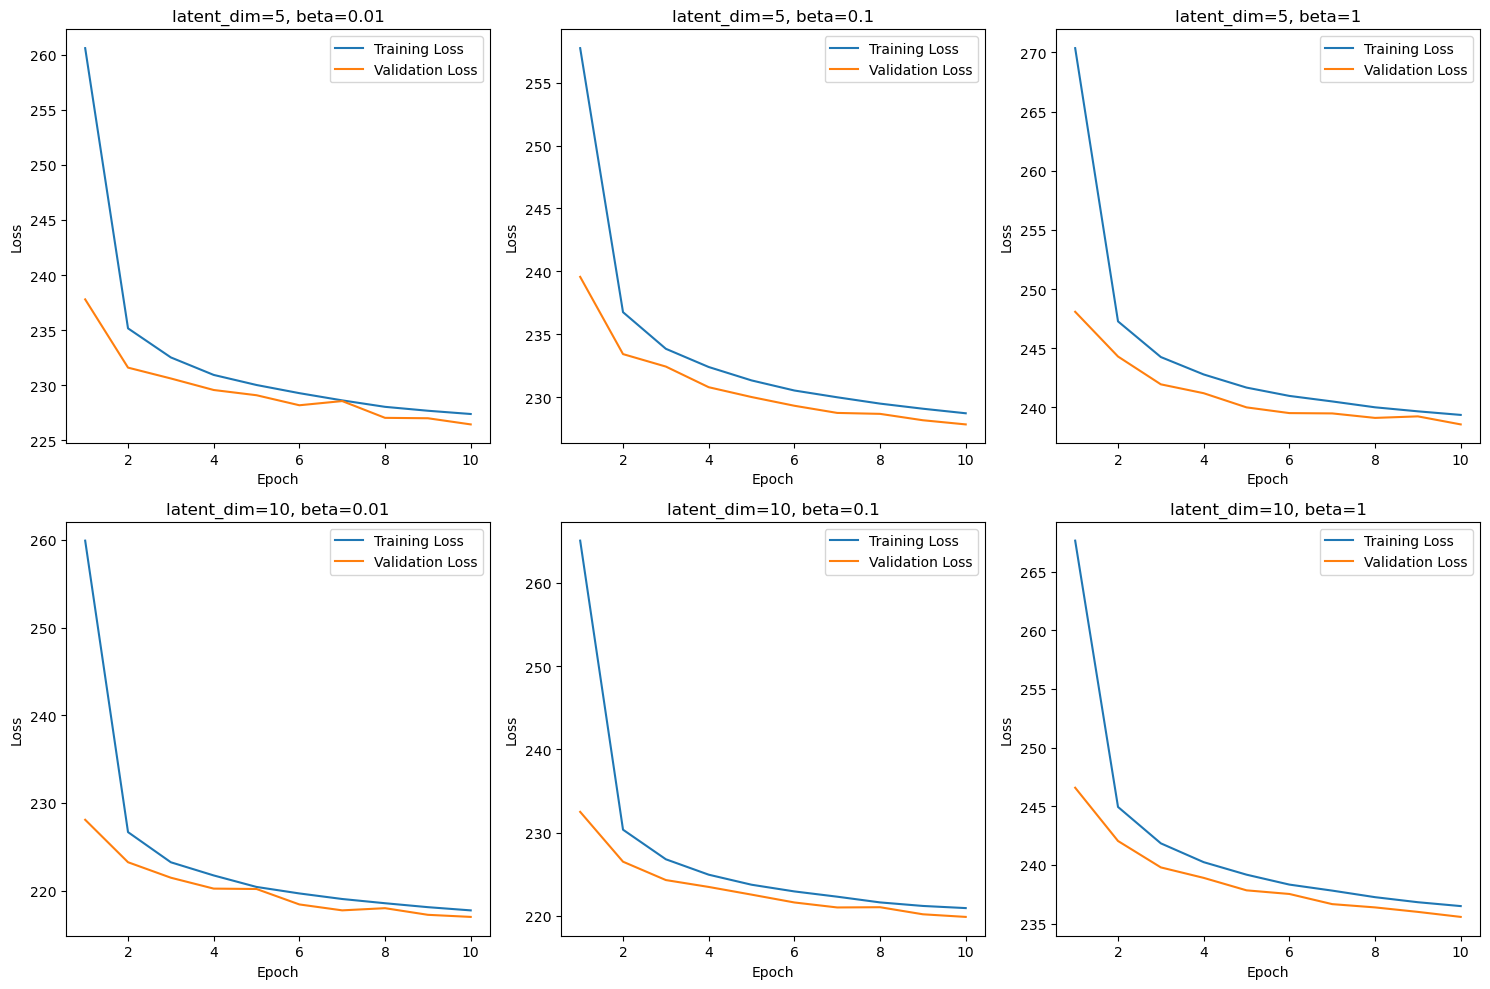

In [137]:
import itertools
import matplotlib.pyplot as plt

# Hyperparamètres
latent_dims = [5, 10] 
betas = [0.01,0.1, 1]      
learning_rate = 1e-3
epochs = 10  
num_classes = 10

results = []

num_combinations = len(latent_dims) * len(betas)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  
axes = axes.flatten() 

# Grid search sur les hyperparamètres
for idx, (latent_dim, beta) in enumerate(itertools.product(latent_dims, betas)):
    print(f'Training with latent_dim={latent_dim} and beta={beta}')
    
    cvae = CVAE(latent_dim=latent_dim, num_classes=num_classes)
    cvae.to(device)
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
    
    train_losses = []
    val_losses = []

    for epoch in range(1, epochs + 1):
        cvae.train()
        running_train_loss = 0.0
        running_val_loss = 0.0

        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = cvae(data, labels)
            loss = loss_function(recon_batch, data, mu, logvar, beta)
            loss.backward()
            optimizer.step()

        train_loss = running_train_loss / len(train_loader.dataset)
        train_losses.append(train_loss)

        # Boucle de validation
        cvae.eval()
        with torch.no_grad():
            for batch_idx, (data, labels) in enumerate(validation_loader):
                data = data.to(device)
                labels = labels.to(device)

                recon_batch, mu, logvar = cvae(data, labels)
                loss = loss_function(recon_batch, data, mu, logvar, beta)
                running_val_loss += loss.item()

        val_loss = running_val_loss / len(validation_loader.dataset)
        val_losses.append(val_loss)

        print(f'Epoch [{epoch}/{epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

    results.append({
        'latent_dim': latent_dim,
        'beta': beta,
        'train_losses': train_losses,
        'val_losses': val_losses,
    })

    ax = axes[idx]
    ax.plot(range(1, epochs + 1), train_losses, label='Training Loss')
    ax.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title(f'latent_dim={latent_dim}, beta={beta}')
    ax.legend()

plt.tight_layout()
plt.show()

**Observations:**

On peut remarquer que pour une dimension latente fixée, plus le beta diminue plus notre fonction de perte diminue. 
Ensuite, pour un beta fixé, on observe que plus la dimension de l'espace latent augmente, plus notre fonction de perte diminue.

Par la suite, on va choisir le plus grand espace latent testé et le plus petit beta et on va augmenter le nombre d'epoch. 

### Impact du nombre d'epochs sur la fonction perte

In [145]:
latent_dim = 10
learning_rate = 1e-3
epochs = 20 # 30
num_classes=10
beta = 0.01

print(f'Training with latent_dim={latent_dim} and beta={beta}')
    
cvae = CVAE(latent_dim=latent_dim, num_classes=num_classes)
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    cvae.train()
    running_train_loss = 0.0
    running_val_loss = 0.0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar,beta)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    cvae.eval()
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(validation_loader):
            data = data.to(device)
            labels = labels.to(device)

            recon_batch, mu, logvar = cvae(data, labels)
            loss = loss_function(recon_batch, data, mu, logvar,beta)
            running_val_loss += loss.item()

    val_loss = running_val_loss / len(validation_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch}/{epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


Training with latent_dim=10 and beta=0.01
Epoch [1/20], Training Loss: 252.8422, Validation Loss: 227.5357
Epoch [2/20], Training Loss: 226.2031, Validation Loss: 223.0656
Epoch [3/20], Training Loss: 222.8733, Validation Loss: 221.2156
Epoch [4/20], Training Loss: 221.1418, Validation Loss: 219.7757
Epoch [5/20], Training Loss: 220.0918, Validation Loss: 219.1703
Epoch [6/20], Training Loss: 219.4023, Validation Loss: 218.3153
Epoch [7/20], Training Loss: 218.7163, Validation Loss: 217.8775
Epoch [8/20], Training Loss: 218.2853, Validation Loss: 217.4099
Epoch [9/20], Training Loss: 217.8063, Validation Loss: 216.9463
Epoch [10/20], Training Loss: 217.4955, Validation Loss: 216.7014
Epoch [11/20], Training Loss: 217.1215, Validation Loss: 216.3956
Epoch [12/20], Training Loss: 216.9481, Validation Loss: 216.4252
Epoch [13/20], Training Loss: 216.6596, Validation Loss: 216.0755
Epoch [14/20], Training Loss: 216.4650, Validation Loss: 215.9424
Epoch [15/20], Training Loss: 216.3227, Val

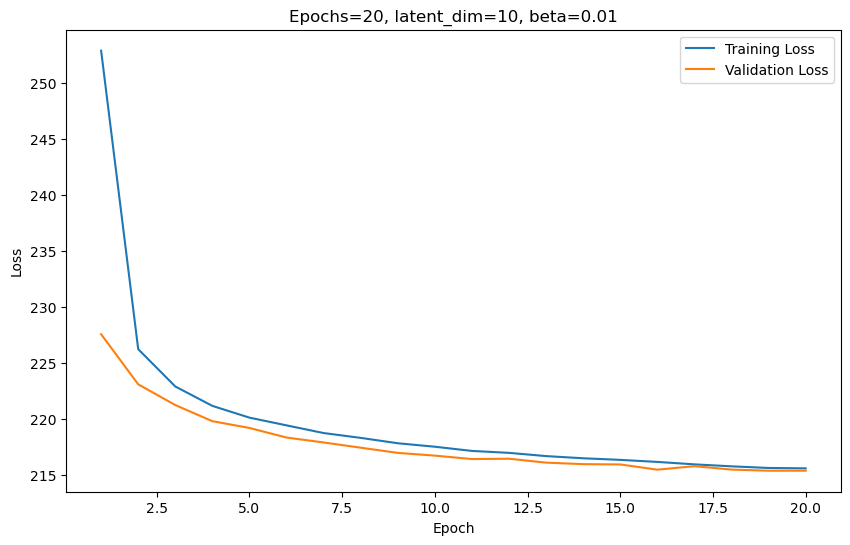

In [152]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epochs=20, latent_dim=10, beta=0.01')
plt.legend()

**Observations:**

On observe que notre fonction de perte converge et plus on augmente le nombre d'epochs plus on atteint la limite de convergence. 

## Affichage des résultats du modèle

### Affichage de la sortie vs entrée

In [147]:
import matplotlib.pyplot as plt

def image_comparison(original_images, reconstructions, n_images=6):
    """Plots the original images and its reconstructions for comparison

    Args:
        original_image (torch.Tensor): The original images
        reconstructions (torch.Tensor): Reconstruction of the original images
    """
    fig, ax = plt.subplots(2, n_images, figsize=(20, 7))

    for i in range(n_images):
        ax[0, i].imshow(original_images[i], cmap='gray')
        ax[0, i].axis('off')
        ax[0, 0].set_title('Original')

        ax[1, i].imshow(reconstructions[i], cmap='gray')
        ax[1, i].axis('off')
        ax[1, 0].set_title('Reconstruction')

    plt.tight_layout()
    plt.show()

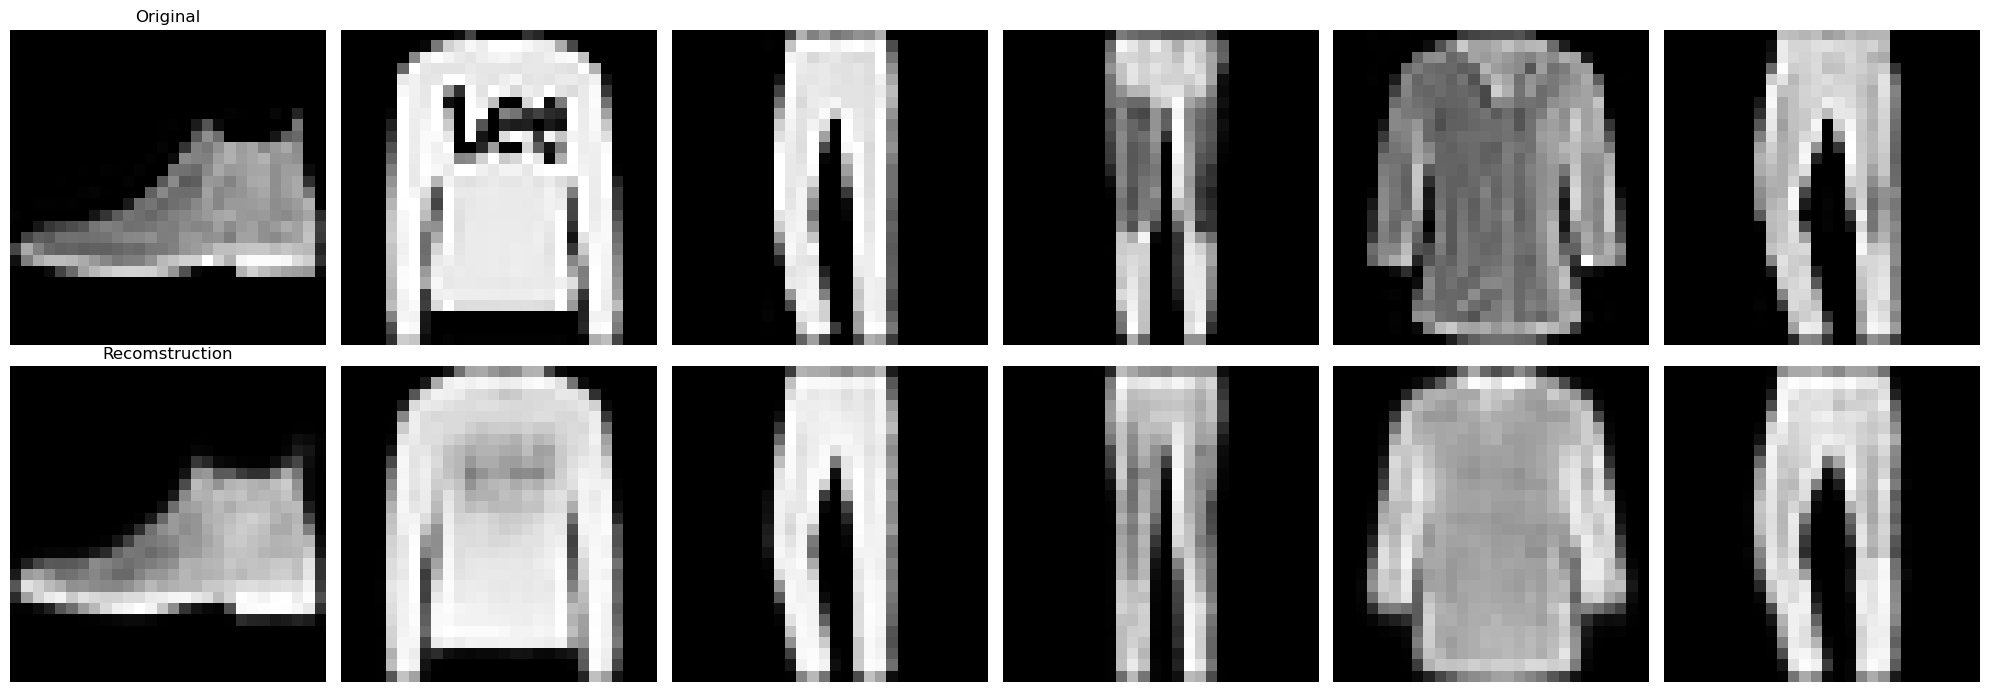

In [148]:
# Obtenir un batch d'images et de labels
data, labels = next(iter(test_loader))
data = data.to(device)
labels = labels.to(device)
cvae.to(device)

recons, _, _ = cvae(data, labels)

# Reshape les images pour l'affichage
random_images = data.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

image_comparison(random_images, recons)


**Observations:**

Ci-dessus on compare nos inputs avec les outputs du modèle. On peut remarquer que notre modèle a bien réussi à reconstruire nos images. 

Cependant, on peut observer que l'on fait du sur-apprentissage car pour le 2e input (T-shirt avec inscription Lee), on a réussi à quasi-reconstruire l'inscription au milieu du t-shirt. On observe également que le modèle tente de reconstruire les détails des pantalons (trous au niveau du genou)

### Generation de nouvelles images

In [149]:
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

In [150]:
def generate_sample(num_samples=5):
    for i in range(10) :
        cvae.eval()
        print(labels_map[i])
        with torch.no_grad():
            z = torch.randn(num_samples, latent_dim).to(device) 

            # Générer des labels pour la classe 'i' (par exemple, 0, 1, 2, ..., 9)
            label_cond = torch.full((num_samples,), i, dtype=torch.long).to('cuda')

            samples = cvae.decode(z,label_cond)
            samples = samples.cpu().view(num_samples, 1, 28, 28)

            fig, ax = plt.subplots(1, num_samples, figsize=(15, 2))
            for i in range(num_samples):
                ax[i].imshow(samples[i].squeeze(0), cmap='gray')
                ax[i].axis('off')
            plt.show()

T-shirt


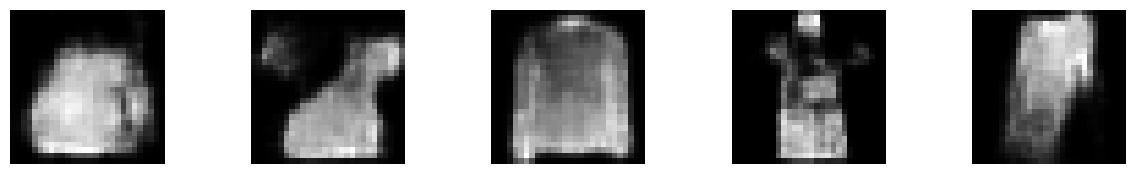

Trouser


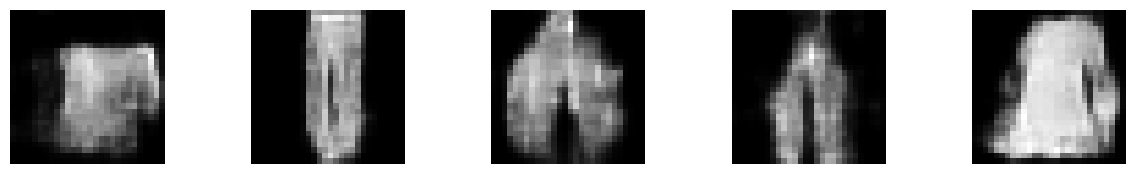

Pullover


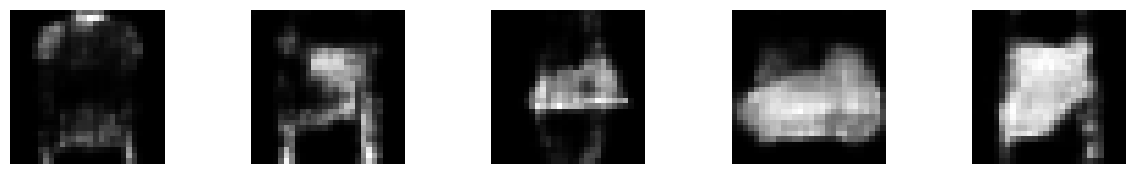

Dress


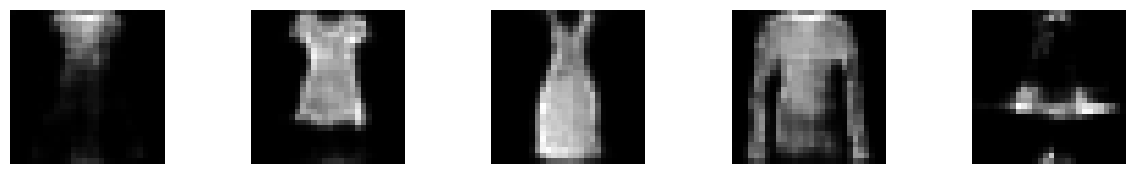

Coat


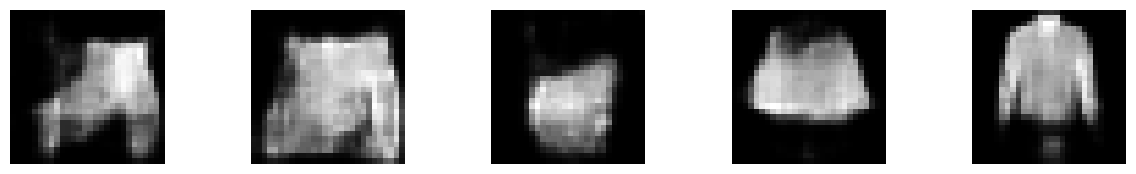

Sandal


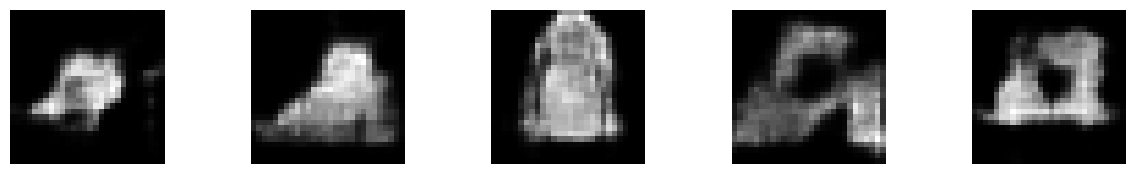

Shirt


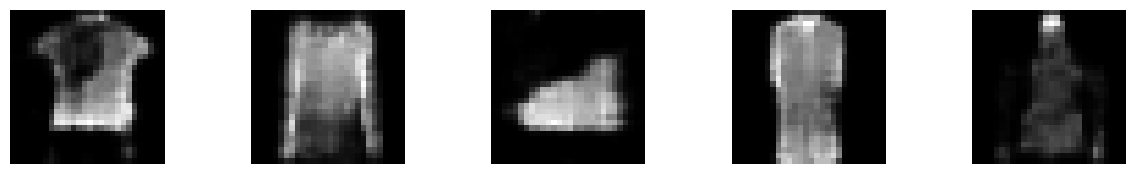

Sneaker


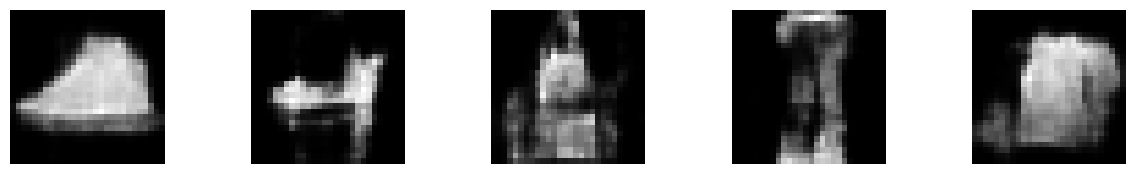

Bag


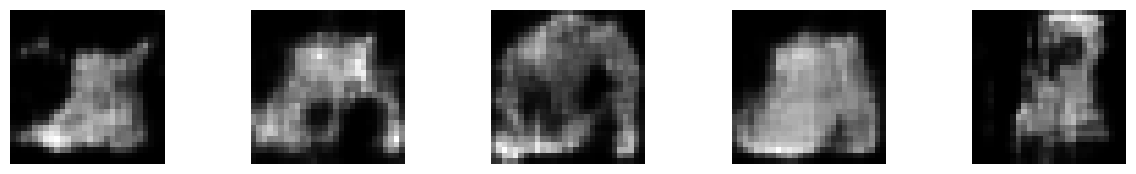

Ankle Boot


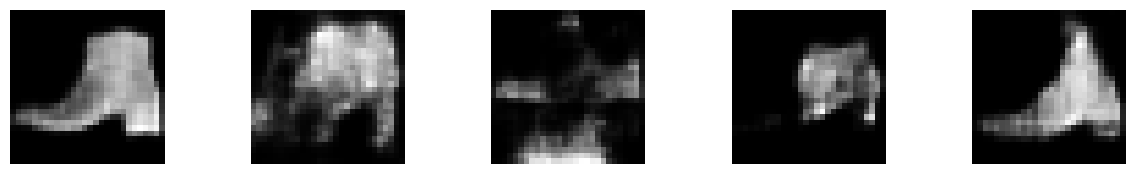

In [151]:
generate_sample()

**Observations:**

On retrouve bien dans cet exemple du surapprentissage. En effet, on a du mal à générer des images à partir d'un bruit gaussien car on a fait du surapprentissage. Ce phénomène est dû notamment au beta. En diminuant beta on a dimuné le poids donné aux distributions de chaque catégories les rendant moins normales. Hors le fait de rendre ces distributions proches d'une gaussienne permet de pouvoir générer des images. 

## Correction du surapprentissage

### Entrainement du modèle

In [153]:
latent_dim = 10
learning_rate = 1e-3
epochs = 20 # 30
num_classes=10
beta = 1

print(f'Training with latent_dim={latent_dim} and beta={beta}')
    
cvae = CVAE(latent_dim=latent_dim, num_classes=num_classes)
cvae.to(device)
optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for epoch in range(1, epochs + 1):
    cvae.train()
    running_train_loss = 0.0
    running_val_loss = 0.0

    for batch_idx, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        recon_batch, mu, logvar = cvae(data, labels)
        loss = loss_function(recon_batch, data, mu, logvar,beta)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    train_loss = running_train_loss / len(train_loader.dataset)
    train_losses.append(train_loss)

    cvae.eval()
    with torch.no_grad():
        for batch_idx, (data, labels) in enumerate(validation_loader):
            data = data.to(device)
            labels = labels.to(device)

            recon_batch, mu, logvar = cvae(data, labels)
            loss = loss_function(recon_batch, data, mu, logvar,beta)
            running_val_loss += loss.item()

    val_loss = running_val_loss / len(validation_loader.dataset)
    val_losses.append(val_loss)

    print(f'Epoch [{epoch}/{epochs}], Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')


Training with latent_dim=10 and beta=1
Epoch [1/20], Training Loss: 267.2406, Validation Loss: 246.8328
Epoch [2/20], Training Loss: 244.9754, Validation Loss: 242.3256
Epoch [3/20], Training Loss: 241.9846, Validation Loss: 240.3313
Epoch [4/20], Training Loss: 240.3636, Validation Loss: 238.4524
Epoch [5/20], Training Loss: 239.2138, Validation Loss: 237.8895
Epoch [6/20], Training Loss: 238.4046, Validation Loss: 237.0845
Epoch [7/20], Training Loss: 237.8857, Validation Loss: 237.8584
Epoch [8/20], Training Loss: 237.3867, Validation Loss: 236.6533
Epoch [9/20], Training Loss: 236.9459, Validation Loss: 236.0134
Epoch [10/20], Training Loss: 236.5835, Validation Loss: 235.4786
Epoch [11/20], Training Loss: 236.2949, Validation Loss: 235.6166
Epoch [12/20], Training Loss: 236.0215, Validation Loss: 235.2547
Epoch [13/20], Training Loss: 235.8205, Validation Loss: 235.0996
Epoch [14/20], Training Loss: 235.6299, Validation Loss: 234.9971
Epoch [15/20], Training Loss: 235.4987, Valida

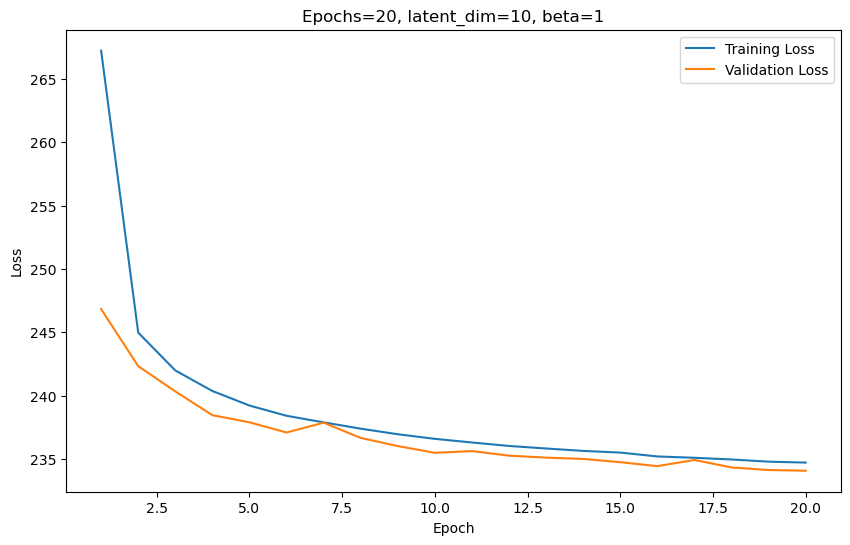

In [154]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epochs=20, latent_dim=10, beta=1')
plt.legend()

### Affichage de la sortie vs entrée

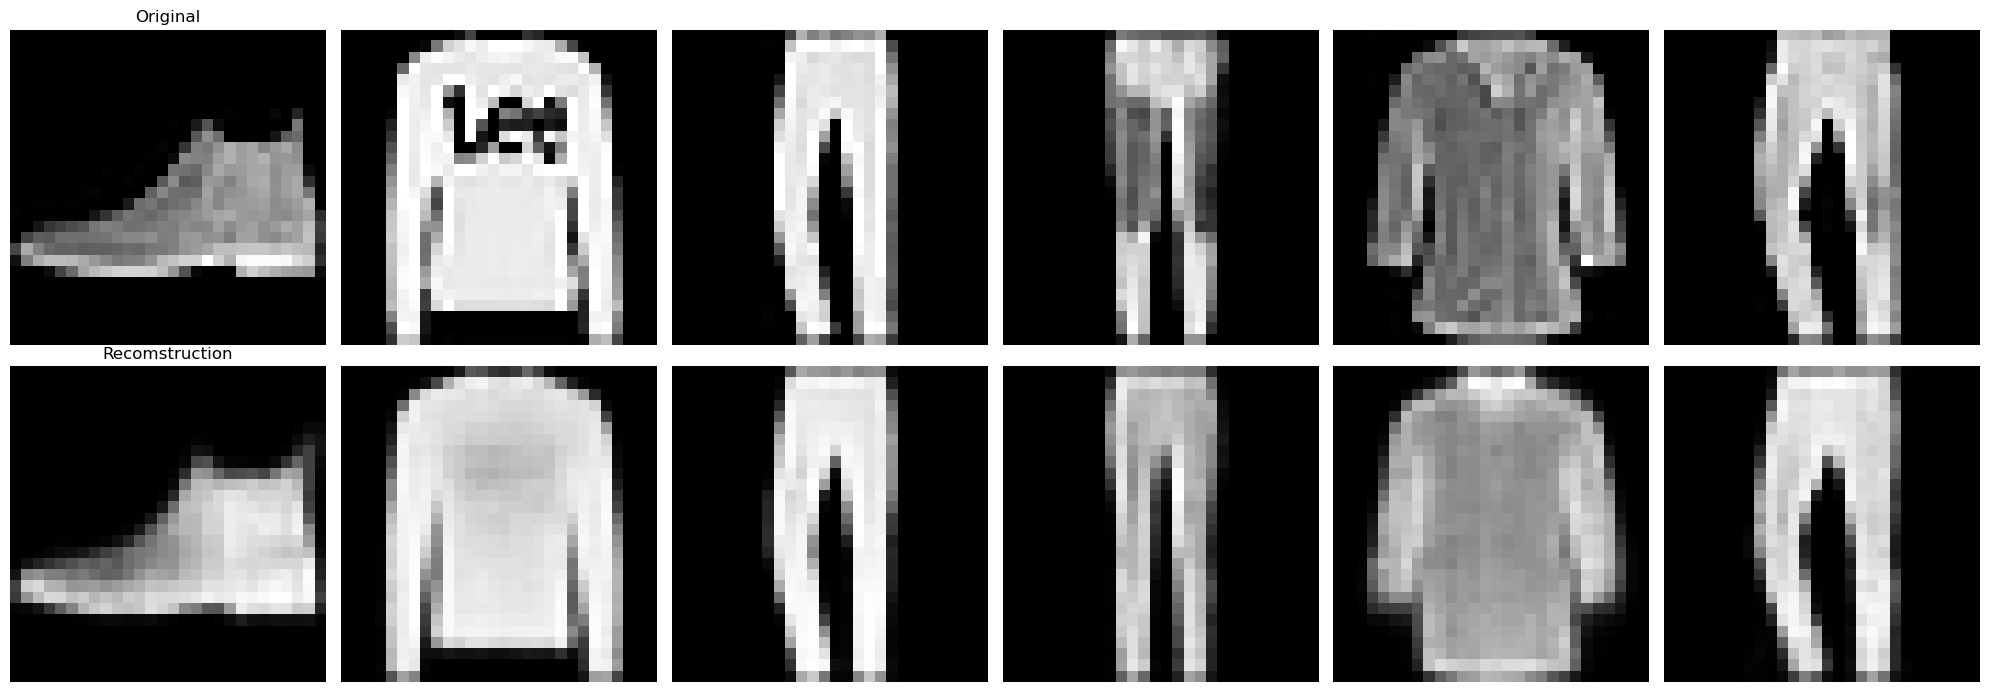

In [155]:
data, labels = next(iter(test_loader))
data = data.to(device)
labels = labels.to(device)
cvae.to(device)

recons, _, _ = cvae(data, labels)

random_images = data.cpu().numpy().squeeze()
recons = recons.detach().cpu().numpy().squeeze()

image_comparison(random_images, recons)


### Génération de nouvelles images

T-shirt


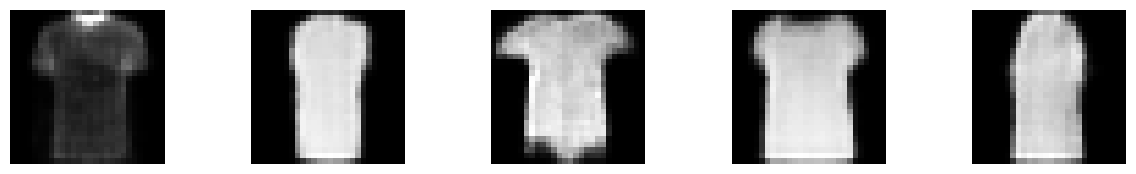

Trouser


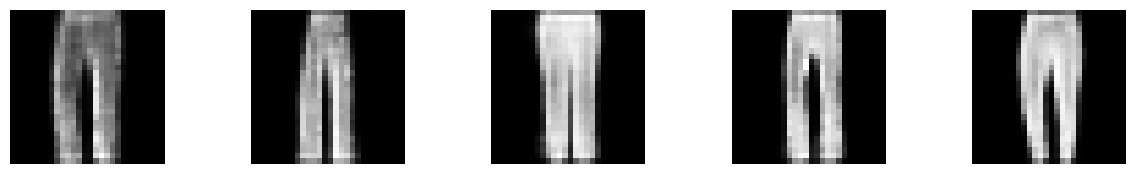

Pullover


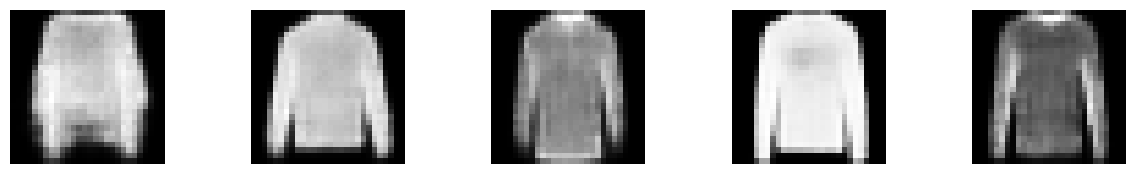

Dress


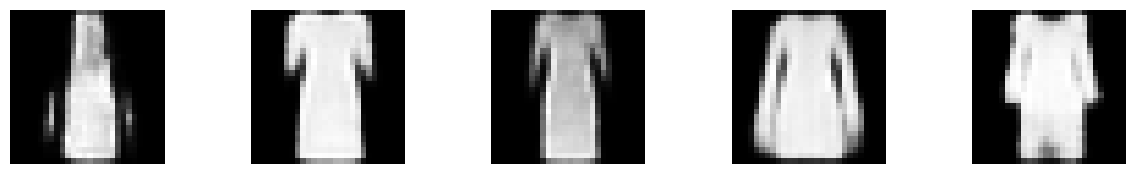

Coat


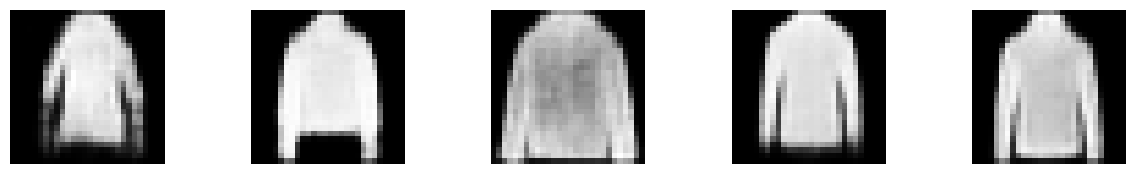

Sandal


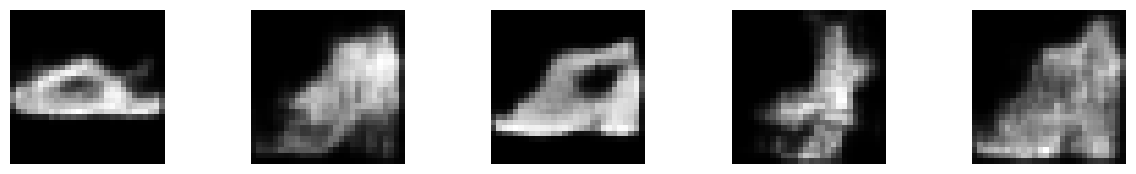

Shirt


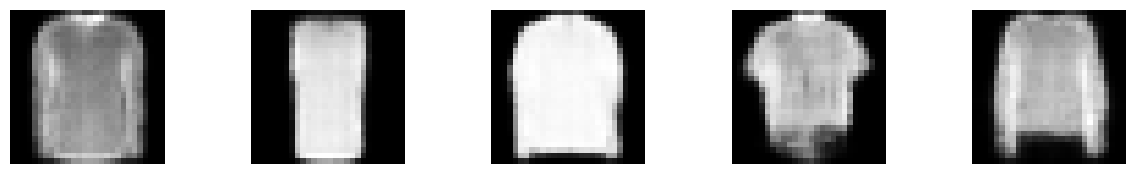

Sneaker


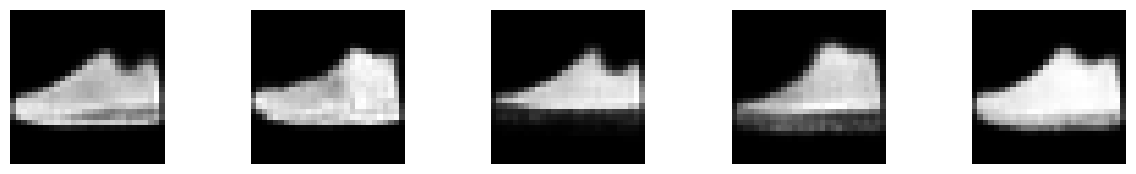

Bag


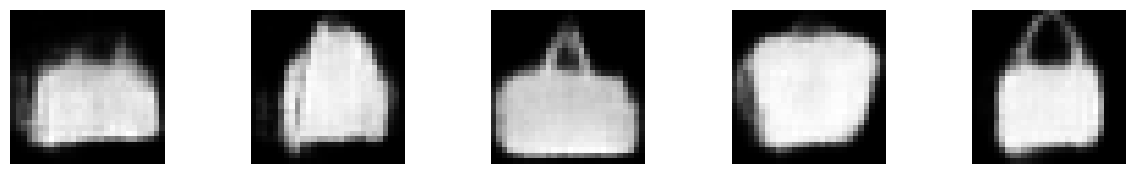

Ankle Boot


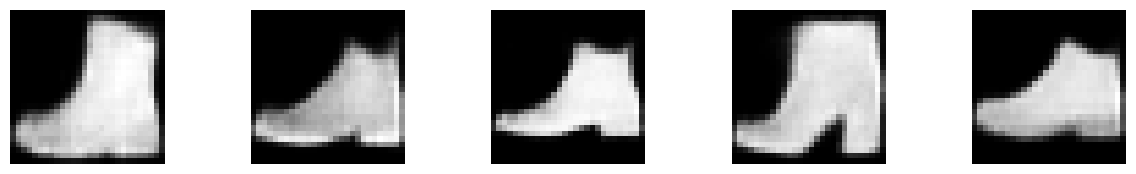

In [156]:
generate_sample()

**Conclusion:**

Si l'on souhaite utiliser cet algorithme afin de faire de la classification il vaut donc mieux utiliser un faible beta. Si l'on veut l'utiliser afin de faire de la génération d'images, on va préférer un beta plus grand.

## Visualisation de l'espace latent 

In [157]:
import matplotlib.pyplot as plt

In [158]:
def loss_function(recon_x, x, mu, logvar, beta=1):

    # Calcul de l'erreur de reconstruction (Binary Cross Entropy)
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # Calcul de la divergence de Kullback-Leibler (KLD)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + beta*KLD, BCE, KLD


Training VAE with KL Weight = 0.01
Epoch 2: Average Loss: 253.3965, BCE: 252.8529, KLD: 54.3614
Epoch 3: Average Loss: 226.1513, BCE: 225.6448, KLD: 50.6529
Epoch 4: Average Loss: 223.0938, BCE: 222.5898, KLD: 50.3946
Epoch 5: Average Loss: 221.3650, BCE: 220.8677, KLD: 49.7234
Epoch 6: Average Loss: 220.2830, BCE: 219.7918, KLD: 49.1186
Epoch 7: Average Loss: 219.4415, BCE: 218.9550, KLD: 48.6523
Epoch 8: Average Loss: 218.8537, BCE: 218.3766, KLD: 47.7057
Epoch 9: Average Loss: 218.3806, BCE: 217.9032, KLD: 47.7470
Epoch 10: Average Loss: 217.9627, BCE: 217.4925, KLD: 47.0283
Epoch 11: Average Loss: 217.6056, BCE: 217.1379, KLD: 46.7711
Epoch 12: Average Loss: 217.3367, BCE: 216.8732, KLD: 46.3585
Epoch 13: Average Loss: 217.0813, BCE: 216.6213, KLD: 46.0015
Epoch 14: Average Loss: 216.7723, BCE: 216.3160, KLD: 45.6305
Epoch 15: Average Loss: 216.6753, BCE: 216.2192, KLD: 45.6077
Epoch 16: Average Loss: 216.3424, BCE: 215.8900, KLD: 45.2410
Epoch 17: Average Loss: 216.2474, BCE: 215

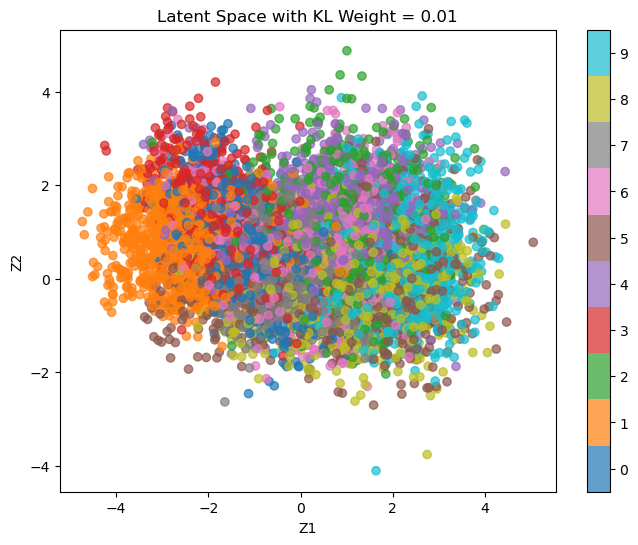


Training VAE with KL Weight = 1
Epoch 2: Average Loss: 266.7263, BCE: 254.9132, KLD: 11.8131
Epoch 3: Average Loss: 244.9649, BCE: 232.6295, KLD: 12.3354
Epoch 4: Average Loss: 241.8267, BCE: 229.5090, KLD: 12.3177
Epoch 5: Average Loss: 240.1558, BCE: 227.8531, KLD: 12.3027
Epoch 6: Average Loss: 239.1390, BCE: 226.8484, KLD: 12.2906
Epoch 7: Average Loss: 238.2698, BCE: 225.9845, KLD: 12.2853
Epoch 8: Average Loss: 237.6697, BCE: 225.3405, KLD: 12.3292
Epoch 9: Average Loss: 237.1940, BCE: 224.8487, KLD: 12.3453
Epoch 10: Average Loss: 236.7439, BCE: 224.3717, KLD: 12.3723
Epoch 11: Average Loss: 236.3523, BCE: 223.9753, KLD: 12.3770
Epoch 12: Average Loss: 236.1234, BCE: 223.7225, KLD: 12.4009
Epoch 13: Average Loss: 235.7682, BCE: 223.3559, KLD: 12.4123
Epoch 14: Average Loss: 235.6874, BCE: 223.2527, KLD: 12.4347
Epoch 15: Average Loss: 235.3835, BCE: 222.9325, KLD: 12.4510
Epoch 16: Average Loss: 235.2251, BCE: 222.7728, KLD: 12.4524
Epoch 17: Average Loss: 235.0363, BCE: 222.58

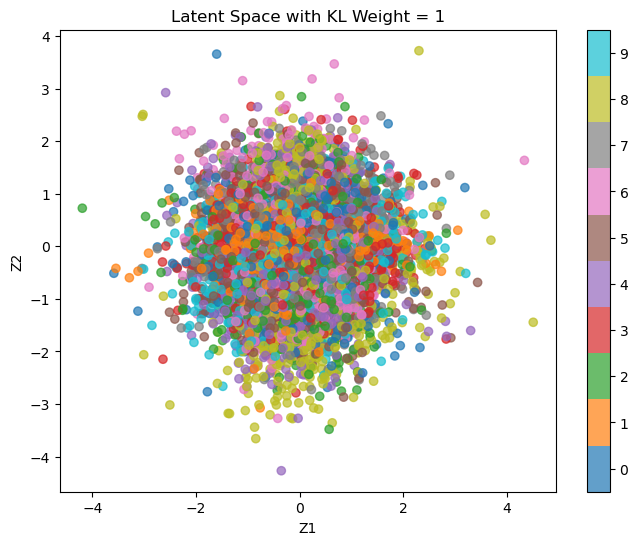

In [160]:

latent_dim = 10
num_epochs = 20
num_classes = 10
learning_rate = 1e-3
kl_weights = [0.01,1] 


def train_and_plot(kl_weight):
    cvae = CVAE(latent_dim=latent_dim, num_classes=num_classes)
    cvae.to(device) 
    optimizer = optim.Adam(cvae.parameters(), lr=learning_rate)
    
    cvae.train()
    train_losses = []
    
    for epoch in range(1, num_epochs):
    
        epoch_loss = 0
        bce_loss = 0
        kld_loss = 0
        for batch_idx, (data, labels) in enumerate(train_loader):
            data = data.to(device) 
            labels = labels.to(device)
    
            optimizer.zero_grad()
            recon_batch, mu, logvar = cvae(data,labels)
            loss, bce, kld = loss_function(recon_batch, data, mu, logvar, beta=kl_weight)
            loss.backward()
            optimizer.step()
    
            epoch_loss += loss.item()
            bce_loss += bce.item()
            kld_loss += kld.item()
    
        average_loss = epoch_loss / len(train_loader.dataset)
        average_bce = bce_loss / len(train_loader.dataset)
        average_kld = kld_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}: Average Loss: {average_loss:.4f}, BCE: {average_bce:.4f}, KLD: {average_kld:.4f}')
    
    plot_latent_space(cvae, kl_weight)

# Function to plot latent space
def plot_latent_space(model, kl_weight,dim1=0,dim2=1):
    model.eval()
    with torch.no_grad():
        test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)
        data, labels = next(iter(test_loader))
        data = data.to(device)
        labels = labels.to(device)
        mu, logvar = model.encode(data,labels)
        z = mu  # For visualization, we use the mean
        z = z.cpu().numpy()
        labels = labels.cpu().numpy()
        
        plt.figure(figsize=(8,6))

        scatter = plt.scatter(z[:, dim1], z[:, dim2], c=labels, cmap='tab10', alpha=0.7)
        plt.colorbar(scatter, ticks=range(10))
        plt.clim(-0.5, 9.5)
        plt.title(f'Latent Space with KL Weight = {kl_weight}')
        plt.xlabel('Z1')
        plt.ylabel('Z2')
        plt.show()

# Run training and plotting for different KL weights
for kl_weight in kl_weights:
    print(f'\nTraining CVAE with KL Weight = {kl_weight}')
    train_and_plot(kl_weight)


**Observations:**

On observe ici que plus le beta est petit plus le KLD est grand. En effet, on diminue le poids de ce terme dans la loss ce qui rend nos distributions moins proches d'une gaussinne d'ou une divergence plus grande. Lorsque'on regarde leur représentation dans l'espace latent, on observe néanmoins que les classes sont plus séparées qu'avec un beta plus grand où elles se superposent.

# Conclusion

Le CVAE est un modèle qui nous permet de contrôler nos images de sorties c'est-à-dire forcer le label de sortie lorsque l'on fait de la génération d'images. Les paramètres du modèles varient en fonction de l'utilisation qu'on en fait. 

Si l'on souhaite reconstruire des images on va préférer donner moins de poids à la distributions de nos variables dans l'espace latent. On a donc une représentation avec des classes plus séparées. 

Si l'on souhaite cependant utiliser ce modèle afin de générer de nouvelles images à partir d'un bruit blanc on va dans ces cas là augmenter le poids donné à la distribution de nos variables dans l'espace latent. On observe bien dans leur représentation que les classes sont moins distinctes mais que leur représentation est plus proche d'une gaussienne.

# Biblio utilisée pour le projet 

**Articles et théorie :** 

https://cedric.cnam.fr/vertigo/cours/RCP211/auto-encodeurs-variationnels.html

https://proceedings.neurips.cc/paper_files/paper/2015/file/8d55a249e6baa5c06772297520da2051-Paper.pdf

https://towardsdatascience.com/understanding-conditional-variational-autoencoders-cd62b4f57bf8

**Codes :** 

https://github.com/lyeoni/pytorch-mnist-CVAE/blob/master/pytorch-mnist-CVAE.ipynb

https://github.com/unnir/cVAE/blob/master/cvae.py
